In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import tweepy
import csv
import pandas as pd
import random
import numpy as np
import pandas as pd

# News Data

In [3]:
# import data
url = 'https://raw.githubusercontent.com/trucntx007/NLP/data/stockerbot-export.csv'
df = pd.read_csv(url, error_bad_lines=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28264 non-null  int64 
 1   text           28264 non-null  object
 2   timestamp      28264 non-null  object
 3   source         28264 non-null  object
 4   symbols        28264 non-null  object
 5   company_names  28263 non-null  object
 6   url            21895 non-null  object
 7   verified       28264 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.5+ MB


b'Skipping line 731: expected 8 fields, saw 13\nSkipping line 2836: expected 8 fields, saw 15\nSkipping line 3058: expected 8 fields, saw 12\nSkipping line 3113: expected 8 fields, saw 12\nSkipping line 3194: expected 8 fields, saw 17\nSkipping line 3205: expected 8 fields, saw 17\nSkipping line 3255: expected 8 fields, saw 17\nSkipping line 3520: expected 8 fields, saw 17\nSkipping line 4078: expected 8 fields, saw 17\nSkipping line 4087: expected 8 fields, saw 17\nSkipping line 4088: expected 8 fields, saw 17\nSkipping line 4499: expected 8 fields, saw 12\n'


In [4]:
df.sample(10).head(5)

,id,text,timestamp,source,symbols,company_names,url,verified
3814,1017485603582238700,Firstenergy Corp $FE Stock Value Rose While Th...,Thu Jul 12 19:07:26 +0000 2018,reurope_stock,FE,FirstEnergy Corp.,https://reurope.com/2018/07/12/firstenergy-cor...,False
26595,1019696729602474000,Copy lucrative traders automatically with Bitc...,Wed Jul 18 21:33:40 +0000 2018,msarybsarstee,ETN,Eaton Corporation plc,https://1broker.com/?r=25023,False
25884,1019684122099216400,https://t.co/0mvtSFNitP #Nadella has done a g...,Wed Jul 18 20:43:34 +0000 2018,paranjpe12,MSFT,Microsoft Corporation,https://www.cnbc.com/2018/07/17/how-microsoft-...,False
23710,1019639090340229100,$TMK New Insider Filing On: LUTEK BEN Transac...,Wed Jul 18 17:44:37 +0000 2018,filing_scanner,TMK,Torchmark Corporation,http://www.filingscanner.com/Alerts/TMK.php,False
11429,1018955475914764300,$BA $JPM $EOG $GS $ORCL $BAC $V $EL $SPB $ACN ...,Mon Jul 16 20:28:11 +0000 2018,teresaarthur66,UTX,United Technologies Corporation,https://twitter.com/i/web/status/1018955475914...,False


# News Data Prep

In [5]:
# Removing special characters

import re
import copy

#df_cleaned = pd.DataFrame(columns=['timestamp','text'])
df_cleaned = df[['timestamp','text', 'symbols']]

spec_cha = "(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
#spec_cha = '[^A-Za-z0-9]+'


df_cleaned['text'] = df_cleaned['text'].replace(to_replace=spec_cha, regex=True, value=' ')
df_cleaned['text'].reset_index(drop=True)
#df_cleaned = [df_cleaned['text'].replace(spec_cha, ' ')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


0        VIDEO   I was in my office  I was minding my o...
1        The price of lumber  LB F is down 22  since hi...
2                   Who says the American Dream is dead   
3        Barry Silbert is extremely optimistic on bitco...
4        How satellites avoid attacks and space junk wh...
                               ...                        
28259            FB   29234a9c 7f08 4d5a 985f cb1a5554ecf9
28260                                              BTC    
28261    RT  invest in hd   Nuff said    TEL  telcoin  ...
28262                                              BTC    
28263    Stellar  XLM price   0 297852 Binance registra...
Name: text, Length: 28264, dtype: object

In [6]:
# get datetime from timestamp
df_cleaned['datetime'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.date())

# sort by 'symbols', 'datetime'
df_cleaned = df_cleaned.sort_values(['symbols', 'datetime'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df_cleaned.head(10)

,timestamp,text,symbols,datetime
11882,Mon Jul 16 23:54:50 +0000 2018,a pa ion du football tait d j connue,A,2018-07-16
11903,Tue Jul 17 00:04:26 +0000 2018,RT ShaneOliverAMP EZ shares 0 2 US shares ...,A,2018-07-17
11981,Tue Jul 17 00:45:27 +0000 2018,The geometric R matrix for affine crystals o...,A,2018-07-17
12026,Tue Jul 17 01:14:22 +0000 2018,I AM ONE EXAM BAM IT CRY OUT HUBS A...,A,2018-07-17
12068,Tue Jul 17 01:44:22 +0000 2018,ACE A FIG CRY TOO BIG I AM MS PEN T...,A,2018-07-17
12201,Tue Jul 17 02:56:35 +0000 2018,The only good moment on tonight s raw a ha,A,2018-07-17
12218,Tue Jul 17 03:11:54 +0000 2018,nicoleyyy17 m4R M1nG 4m p A 0r,A,2018-07-17
12224,Tue Jul 17 03:14:38 +0000 2018,MY INN ATE A RACE AT A KING STAY TEN...,A,2018-07-17
12259,Tue Jul 17 03:41:26 +0000 2018,RT freshagenda2013 OK so maybe you re not as...,A,2018-07-17
12309,Tue Jul 17 04:14:20 +0000 2018,IM OUT A GAS I ACE ALL KEYS AGO DATA...,A,2018-07-17


In [8]:
# new dataframe to house combined text
# text of the same company (same symbol) on a same date will be groupped together

df_cleaned1 = pd.DataFrame(columns=['datetime','text','symbols'])


In [9]:
# grouping text that have the same symbol to one row
# then group by date
indx=0
get_tweet=""
for i in range(0,len(df_cleaned)-1):
    get_date = df_cleaned['datetime'].iloc[i]
    next_date = df_cleaned['datetime'].iloc[i+1]

    get_symbols = df_cleaned['symbols'].iloc[i]
    next_symbols = df_cleaned['symbols'].iloc[i+1]

    if(str(get_symbols) == str(next_symbols)): 
      if(str(get_date) != str(next_date)):
        get_tweet = df_cleaned['text'].iloc[i]

        temp_df = pd.DataFrame([[get_date, get_tweet, get_symbols]]
                               , columns = ['Date','text','symbols'])  
        df_cleaned1 = pd.concat([df_cleaned1, temp_df], axis = 0).reset_index(drop = True)
        
        get_tweet=" "
      else:
        get_tweet = get_tweet + df_cleaned['text'].iloc[i]+" "
    else: 
      #if (str(get_date) != str(next_date)):
      temp_df = pd.DataFrame([[get_date, get_tweet, get_symbols]]
                               , columns = ['Date','text','symbols'])
      df_cleaned1 = pd.concat([df_cleaned1, temp_df], axis = 0).reset_index(drop = True)
      get_tweet=" "

In [10]:
df_cleaned1

,datetime,text,symbols,Date
0,NaN,a pa ion du football tait d j connue,A,2018-07-16
1,NaN,A repeat of 2002 Walmart may be looking to...,A,2018-07-17
2,NaN,ACE OUT A CGI HE PAY ALL DATA YELP ...,A,2018-07-18
3,NaN,myhedghog Yeah I saw AABA was selling roughl...,AABA,2018-07-11
4,NaN,BABA YAHOY AABA,AABA,2018-07-12
...,...,...,...,...
2303,NaN,Zoetis Inc ZTS Given Average Rating of Buy ...,ZTS,2018-07-15
2304,NaN,Scan results MACD Bearish Centerline Cross t...,ZTS,2018-07-16
2305,NaN,ZTS Zoetis Inc SEC Filing Form 4,ZTS,2018-07-17
2306,NaN,ZTS New Insider Filing On Fenton Andrew Tr...,ZTS,2018-07-18


In [11]:
# drop 'datetime' column since already created 'Date'
df_cleaned1 = df_cleaned1.dropna(axis=1)

In [12]:
# df_cleaned1 has tweets groupby symbols and Date
df_cleaned1.sort_values('symbols')

,text,symbols,Date
0,a pa ion du football tait d j connue,A,2018-07-16
1,A repeat of 2002 Walmart may be looking to...,A,2018-07-17
2,ACE OUT A CGI HE PAY ALL DATA YELP ...,A,2018-07-18
10,Head To Head Analysis Unisys UIS and Altaba...,AABA,2018-07-18
8,Today s million dollar PUT options trade AM...,AABA,2018-07-16
...,...,...,...
2299,Analyst portfolio manager hunting ideas Her...,ZTS,2018-07-11
2298,Abaxis ABAX and Zoetis Merger Deal Crosses H...,ZTS,2018-07-10
2306,ZTS New Insider Filing On Fenton Andrew Tr...,ZTS,2018-07-18
2301,ZTS the bull pattern is confirmed amp a BUY...,ZTS,2018-07-13


In [13]:
# Split timestamp
# df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'],format='%Y-%m-%d')

# df_cleaned[['dayofweek','month','day','time','timezone', 'year']] = df_cleaned.timestamp.str.split(expand=True)
# df_cleaned[['hour','minute','second']] = df_cleaned.time.str.split(':',expand=True)

# df_cleaned['datetime'] = df_cleaned[['year', 'month', 'day']].agg('-'.join, axis=1)


# Stock Data

In [14]:
stocks = pd.read_csv('https://raw.githubusercontent.com/trucntx007/NLP/main/stocks_cleaned.csv')
# Define the ticker list

tickers_list = []

for i in range(len(stocks)):
  tickers = stocks['ticker'][i]
  tickers_list.append(tickers)


In [ ]:
tickers_list

In [16]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [17]:
# Fetch data from Yahoo Finance
import yfinance as yf

data = yf.download(tickers_list, start='2018-7-9',end='2018-7-19')['Adj Close']

# Drop cols with no data
data = data.dropna(axis=1)

# Print first 5 rows of the data
print(data.head())



[*********************100%***********************]  583 of 583 completed

65 Failed downloads:
- VAR: No data found, symbol may be delisted
- AMTD: No data found, symbol may be delisted
- GG: No data found, symbol may be delisted
- TMK: No data found, symbol may be delisted
- SPN: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- WYN: No data found for this date range, symbol may be delisted
- DPS: No data found for this date range, symbol may be delisted
- CHK: Data doesn't exist for startDate = 1531094400, endDate = 1531958400
- HCP: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- GGP: No data found for this date range, symbol may be delisted
- LUK: No data found for this date range, symbol may be delisted
- S: Data doesn't exist for startDate = 1531094400, endDate = 1531958400
- GLUU: No data found, symbol may be delisted
- FOXA: Data doesn't exist

In [18]:
# add column datetime
data[data.index.name] = data.index

In [19]:
# Transpose stock dataset
data_T = data
data_T = data_T.transpose()
data_T['symbols'] = data_T.index

In [20]:
# price of a stock during the period
data_Tr = data_T.melt(id_vars=['symbols'],var_name="Date", value_name='Price')
data_Tr.sort_values(['symbols', 'Date'])

,symbols,Date,Price
0,A,2018-07-09,61.5467
519,A,2018-07-10,62.0829
1038,A,2018-07-11,61.2931
1557,A,2018-07-12,61.8684
2076,A,2018-07-13,61.8002
...,...,...,...
2074,ZTS,2018-07-12,83.7446
2593,ZTS,2018-07-13,84.4011
3112,ZTS,2018-07-16,82.8726
3631,ZTS,2018-07-17,84.0385


In [21]:
# get list of symbols
tickers_list = pd.Series(data_Tr['symbols'].unique())
tickers_list.to_csv('tickerlist.csv')

In [22]:
# save stock prices to StockData.csv
data.to_csv('StockData.csv')

# Combine datasets

In [23]:
# add column 'Price' to df_cleaned1
df_cleaned1['Price'] = ''

In [24]:
df_cleaned1.sort_values('symbols')

,text,symbols,Date,Price
0,a pa ion du football tait d j connue,A,2018-07-16,
1,A repeat of 2002 Walmart may be looking to...,A,2018-07-17,
2,ACE OUT A CGI HE PAY ALL DATA YELP ...,A,2018-07-18,
10,Head To Head Analysis Unisys UIS and Altaba...,AABA,2018-07-18,
8,Today s million dollar PUT options trade AM...,AABA,2018-07-16,
...,...,...,...,...
2299,Analyst portfolio manager hunting ideas Her...,ZTS,2018-07-11,
2298,Abaxis ABAX and Zoetis Merger Deal Crosses H...,ZTS,2018-07-10,
2306,ZTS New Insider Filing On Fenton Andrew Tr...,ZTS,2018-07-18,
2301,ZTS the bull pattern is confirmed amp a BUY...,ZTS,2018-07-13,


In [25]:
# append 'Price' from Stock Dataset to News Dataset
for i in range (0,len(df_cleaned1)):
    for j in range (0,len(data_Tr)):
        get_tweet_date = df_cleaned1['Date'].iloc[i]
        get_stock_date = (data_Tr['Date'].iloc[j]).date() # get rid of 00:00:00
        
        get_tweet_symbol = df_cleaned1['symbols'].iloc[i]
        get_stock_symbol = data_Tr['symbols'].iloc[j]

        if(str(get_tweet_symbol) == str(get_stock_symbol) and 
           (str(get_stock_date) == str(get_tweet_date))):
            #print(get_stock_date," ",get_tweet_date)
            df_cleaned1['Price'].iloc[i] = int(data_Tr['Price'][j])

In [26]:
# fill missing 'Price' with the most recent price
for i in range(len(df_cleaned1)):
  if df_cleaned1['Price'].iloc[i] == '':
    df_cleaned1['Price'].iloc[i] = df_cleaned1['Price'].iloc[i-1] 

In [27]:
combined_data = df_cleaned1
combined_data.to_csv('combined_data.csv')

In [28]:
# convert 'Price' to integer
combined_data['Price'] = combined_data['Price'].apply(np.int64)

# adding columns for sentiment analysis
combined_data['Emotion'] = ''
combined_data['Negative'] = ''
combined_data['Neutral'] = ''
combined_data['Positive'] = ''


In [29]:
# Sentiment Analysis with vader
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in combined_data.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', combined_data.loc[indexx, 'text'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        combined_data['Emotion'].iloc[indexx] = sentence_sentiment['compound']
        combined_data['Negative'].iloc[indexx] = sentence_sentiment['neg']
        combined_data['Neutral'].iloc[indexx] = sentence_sentiment['neu']
        combined_data['Positive'].iloc[indexx] = sentence_sentiment['compound']
        
    except TypeError:
        print (stocks_dataf.loc[indexx, 'text'])
        print (indexx)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [31]:
combined_data

,text,symbols,Date,Price,Emotion,Negative,Neutral,Positive
0,a pa ion du football tait d j connue,A,2018-07-16,61,0,0,1,0
1,A repeat of 2002 Walmart may be looking to...,A,2018-07-17,61,0,0,1,0
2,ACE OUT A CGI HE PAY ALL DATA YELP ...,A,2018-07-18,61,0.9657,0.033,0.887,0.9657
3,myhedghog Yeah I saw AABA was selling roughl...,AABA,2018-07-11,61,0.296,0,0.879,0.296
4,BABA YAHOY AABA,AABA,2018-07-12,61,0,0,1,0
...,...,...,...,...,...,...,...,...
2303,Zoetis Inc ZTS Given Average Rating of Buy ...,ZTS,2018-07-15,84,0,0,1,0
2304,Scan results MACD Bearish Centerline Cross t...,ZTS,2018-07-16,82,0,0,1,0
2305,ZTS Zoetis Inc SEC Filing Form 4,ZTS,2018-07-17,84,0,0,1,0
2306,ZTS New Insider Filing On Fenton Andrew Tr...,ZTS,2018-07-18,84,-0.0258,0.025,0.943,-0.0258


# NLP Text Processing

In [32]:
import re
import nltk
import ssl
 

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [33]:
!pip install langdetect

     |████████████████████████████████| 981 kB 5.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=7630c11631bef80b079e040f229fe638502f75bd44e9d464a1cbfe8a0bba7720
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [34]:
# Remove Stop words
freq = pd.Series(' '.join(df_cleaned['text']).lower().split()).value_counts()[:20]
freq

stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(freq.index.tolist())
extra_words = ['amp', 'rt']
stop_words = stop_words.union(extra_words)

In [35]:
# Processing language 

from langdetect import detect_langs

#check for valid string only to detect languages
TextValid=[]

for i in range(len(df_cleaned)):
    TextValid.append(bool(re.match('^(?=.*[a-zA-Z])', df_cleaned.iloc[i,0])))
    
df_cleaned['valid'] = TextValid
#print(len(df_cleaned[df_cleaned['valid']==False]))
#print(len(df_cleaned[df_cleaned['valid']==True]))

# Detect languages for each text
languages = []

# Loop over the sentences in the data and detect their language
for row in range(len(df_cleaned)):
    languages.append(detect_langs(df_cleaned.iloc[row, 0]))
    
languages = [str(lang).split(':')[0][1:] for lang in languages] 

# Assign the list to a new feature 
df_cleaned['language'] = languages

# count the languages in the data
df_cleaned['language'].value_counts()

# keep EN Only
df_cleaned = df_cleaned[df_cleaned['language']=='en']

In [36]:
df_cleaned

,timestamp,text,symbols,datetime,valid,language
11882,Mon Jul 16 23:54:50 +0000 2018,a pa ion du football tait d j connue,A,2018-07-16,True,en
11903,Tue Jul 17 00:04:26 +0000 2018,RT ShaneOliverAMP EZ shares 0 2 US shares ...,A,2018-07-17,True,en
11981,Tue Jul 17 00:45:27 +0000 2018,The geometric R matrix for affine crystals o...,A,2018-07-17,True,en
12026,Tue Jul 17 01:14:22 +0000 2018,I AM ONE EXAM BAM IT CRY OUT HUBS A...,A,2018-07-17,True,en
12068,Tue Jul 17 01:44:22 +0000 2018,ACE A FIG CRY TOO BIG I AM MS PEN T...,A,2018-07-17,True,en
...,...,...,...,...,...,...
22909,Wed Jul 18 16:33:47 +0000 2018,Analysts Set Zoetis Inc ZTS Target Price at ...,ZTS,2018-07-18,True,en
23078,Wed Jul 18 16:49:49 +0000 2018,Zoetis Inc ZTS to Issue Quarterly Dividend of...,ZTS,2018-07-18,True,en
23097,Wed Jul 18 16:50:59 +0000 2018,Zoetis Inc ZTS to Issue Quarterly Dividend of...,ZTS,2018-07-18,True,en
23696,Wed Jul 18 17:43:22 +0000 2018,ZTS New Insider Filing On Fenton Andrew Tra...,ZTS,2018-07-18,True,en


In [37]:
corpus = []
for i in df_cleaned.index:
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_cleaned['text'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ",text)
    text = text.replace("\n","")
   
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    df_cleaned['keywords'] = pd.Series(text)
    text = " ".join(text)
    corpus.append(text)
    
pd.Series(corpus).sample(20).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


19605    estate asset watch today outsized price move s...
2402     evening tweeted mid cap check gambiste top hel...
16908    see cdix offer msft amzn fb goog jnj jpm googo...
17246                             g plc long term investor
11476    keefe bruyette wood lower invesco ivz market p...
22220        patience value name xrx make back zone beyond
22006    xec open interest maturity high put high call ...
20358                                txt premarket winning
13116                                         miniapps mat
2484               analyst see eps avalonbay community avb
14362                        mtb new sec filing mtb form k
10920    illumina ilmn reach new month high analyst upg...
16382    pultegroup phm v tri pointe group tph financia...
19715                broker issue forecast mobile u q tmus
22486    try gauge sentiment ticker come search crypto ...
15420    spy break keep eye amzn nflx fb aapl googl tsl...
12194    join u signal multiple paid group one join u g.

# Sentiment Analysis

In [39]:
!pip install textblob

In [40]:
# Detect Emotions for each text Form TextBlob Library
from textblob import TextBlob

detectEmotion = []
detectPolarity = []

for txt in corpus:
    analysis = TextBlob(txt)
    Polarity = analysis.sentiment.polarity
    
    if Polarity < 0:
        emotion = '2'  #Negative
    elif Polarity > 0: 
        emotion = '1'  #Positive
    else:
        emotion = '0'  #Neutral
        
    detectEmotion.append(emotion)
    detectPolarity.append(Polarity)
    
df_cleaned['Polarity'] = detectPolarity
df_cleaned['Emotion'] = detectEmotion

In [41]:
df_cleaned.sort_values(by = ['timestamp'])
#jul-9-2018
#jul-18

,timestamp,text,symbols,datetime,valid,language,keywords,Polarity,Emotion
47,Mon Jul 09 00:15:27 +0000 2018,NI high OI range is 26 00 to 26 00 for option...,NI,2018-07-09,True,en,NaN,0.160000,1
48,Mon Jul 09 00:17:21 +0000 2018,RT TradeSatoshi AMG AMGCHAIN will be delis...,AMG,2018-07-09,True,en,NaN,0.000000,0
49,Mon Jul 09 00:17:35 +0000 2018,Payments halted under Obamacare program UNH...,HCA,2018-07-09,True,en,NaN,0.000000,0
50,Mon Jul 09 00:21:28 +0000 2018,RT forever t 2000 Theres goes SODE breaking...,JEC,2018-07-09,True,en,NaN,-0.300000,2
51,Mon Jul 09 00:31:10 +0000 2018,JEC Max Pain 65 00 Maturity 07 20 2018 max...,JEC,2018-07-09,True,en,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...
28259,Wed Jul 18 23:46:13 +0000 2018,FB 29234a9c 7f08 4d5a 985f cb1a5554ecf9,FB,2018-07-18,True,en,NaN,0.000000,0
28261,Wed Jul 18 23:46:19 +0000 2018,RT invest in hd Nuff said TEL telcoin ...,BTC,2018-07-18,True,en,NaN,0.000000,0
28260,Wed Jul 18 23:46:19 +0000 2018,BTC,BTC,2018-07-18,True,en,NaN,0.000000,0
28262,Wed Jul 18 23:46:20 +0000 2018,BTC,BTC,2018-07-18,True,en,NaN,0.000000,0


In [42]:
# Percentage of each Emotions overall symbols

df_neutral   = df_cleaned['text'][df_cleaned['Emotion'] == '0']
df_positive  = df_cleaned['text'][df_cleaned['Emotion'] == '1']
df_negative  = df_cleaned['text'][df_cleaned['Emotion'] == '2']

In [43]:
print(f'Percentage Positive: {len(df_positive)/len(df_cleaned)}')
print(f'Percentage Negetive: {len(df_negative)/len(df_cleaned)}')
print(f'Percentage Neutral: {len(df_neutral)/len(df_cleaned)}')

Percentage Positive: 0.2766932005158536
Percentage Negetive: 0.12304887268199403
Percentage Neutral: 0.6002579268021524


# NLP Models

In [44]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(df_cleaned['text'], df_cleaned['Emotion'], test_size=0.2, random_state=50)

In [45]:
# Ngram Models
def NgramModels(Model , txt, n):
    vect      = CountVectorizer(max_features=1000 , ngram_range=(n,n))
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    model     = Model
    t0        = time.time()
    model.fit(train_vect, y_train)
    t1        = time.time()
    predicted = model.predict(test_vect)
    t2        = time.time()
    time_train= t1-t0
    time_pred = t2-t1
    
    accuracy  = model.score(train_vect, y_train)
    predicted = model.predict(test_vect)
    
    report = classification_report(y_test, predicted, output_dict=True)
    print("Models with " , n , "-grams :\n")
    print('********************** \n')
    print(txt)
    print("Training time: %fs; Prediction time: %fs \n" % (time_train, time_pred))
    print('Accuracy score train set :', accuracy)
    print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
    print('Positive: ', report['1'])
    print('Neutral : ', report['0'])
    print('Negative: ', report['2'])
    print('\n --------------------------------------------------------------------------------------------------- \n')

In [46]:
def KNN_Ngram(n):
    vect      = CountVectorizer(max_features=1000 , ngram_range=(n,n))
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    for k in [1,3,5,7,10]:
        model = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        t0        = time.time()
        model.fit(train_vect, y_train)
        t1        = time.time()
        predicted = model.predict(test_vect)
        t2        = time.time()
        time_train= t1-t0
        time_pred = t2-t1

        accuracy  = model.score(train_vect, y_train)
        predicted = model.predict(test_vect)

        report = classification_report(y_test, predicted, output_dict=True)

        print("Models with " , n , "-grams :\n")
        print('********************** \n')
        print("Classification Report for k = {} is:\n".format(k))
        print("Training time: %fs ; Prediction time: %fs \n" % (time_train, time_pred))
        print('Accuracy score train set :', accuracy)
        print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
        print('Positive: ', report['1'])
        print('Neutral : ', report['0'])
        print('Negative: ', report['2'])
        print('\n -------------------------------------------------------------------------------------- \n')

In [47]:
def TFIDFModels(Model,txt):
    vect      = TfidfVectorizer(min_df = 5, max_df =0.8, sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    model     = Model
    t0        = time.time()
    model.fit(train_vect, y_train)
    t1        = time.time()
    predicted = model.predict(test_vect)
    t2        = time.time()
    time_train= t1-t0
    time_pred = t2-t1
    
    accuracy  = model.score(train_vect, y_train)
    predicted = model.predict(test_vect)
    
    report = classification_report(y_test, predicted, output_dict=True)
    
    print(txt)
    print("Training time: %fs; Prediction time: %fs \n" % (time_train, time_pred))
    print('Accuracy score train set :', accuracy)
    print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
    print('Positive: ', report['1'])
    print('Neutral : ', report['0'])
    print('Negative: ', report['2'])
    print('\n -------------------------------------------------------------------------------------- \n')

In [48]:
def KNN_TFIDF():
    vect      = TfidfVectorizer(min_df = 5, max_df =0.8, sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    for k in [1,3,5,7,10]:

        model = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        t0        = time.time()
        model.fit(train_vect, y_train)
        t1        = time.time()
        predicted = model.predict(test_vect)
        t2        = time.time()
        time_train= t1-t0
        time_pred = t2-t1

        accuracy  = model.score(train_vect, y_train)
        predicted = model.predict(test_vect)

        report = classification_report(y_test, predicted, output_dict=True)

        print("Classification Report for k = {} is:\n".format(k))
        print("Training time: %fs ; Prediction time: %fs \n" % (time_train, time_pred))
        print('Accuracy score train set :', accuracy)
        print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
        print('Positive: ', report['1'])
        print('Neutral : ', report['0'])
        print('Negative: ', report['2'])
        print('\n -------------------------------------------------------------------------------------- \n')


# Train Models and Make Predictions

In [49]:
SupportVectorClassifier=svm.SVC(kernel='linear')

LogReg2 = NgramModels(Model = LogisticRegression(),txt = '\nLogistic Regression Model : \n ', n=2)
LogReg3 = NgramModels(Model = LogisticRegression(),txt = 'Logistic Regression Model : \n ', n=3)

svm2 = NgramModels(Model = SupportVectorClassifier ,txt = 'Support Vectoer Classifier Model : \n ', n=2)
svm3 = NgramModels(Model = SupportVectorClassifier ,txt = 'Support Vectoer Classifier Model : \n ', n=3)

DecTree2 = NgramModels(Model = tree.DecisionTreeClassifier(),txt = 'Decision Tree Classifier Model : \n ', n=2)
DecTree3 = NgramModels(Model = tree.DecisionTreeClassifier(),txt = 'Decision Tree Classifier Model : \n ', n=3)

KNN2=KNN_Ngram(2)
KNN3=KNN_Ngram(3)

print('Models with Tfidf Feature extraction Techniques : \n')
print('************************************************ \n')

LogReg = TFIDFModels(Model = LogisticRegression(),txt = 'Logistic Regression Model : \n ')
svm = TFIDFModels(Model = SupportVectorClassifier,txt = 'Support Vector Classifier Model : \n ')
DecTree = TFIDFModels(Model = tree.DecisionTreeClassifier(),txt = 'Decision Tree Classifier Model : \n ')
knn_tfidf = KNN_TFIDF()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Models with  2 -grams :

********************** 


Logistic Regression Model : 
 
Training time: 0.887120s; Prediction time: 0.000559s 

Accuracy score train set : 0.7908721996775807
Accuracy score test set  : 0.7839039573143619 

Positive:  {'precision': 0.8270348837209303, 'recall': 0.47774979009235935, 'f1-score': 0.6056412985630655, 'support': 1191}
Neutral :  {'precision': 0.7602996254681648, 'recall': 0.9627873039036848, 'f1-score': 0.8496458467482292, 'support': 2741}
Negative:  {'precision': 0.9380530973451328, 'recall': 0.5618374558303887, 'f1-score': 0.7027624309392264, 'support': 566}

 --------------------------------------------------------------------------------------------------- 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Models with  3 -grams :

********************** 

Logistic Regression Model : 
 
Training time: 0.764985s; Prediction time: 0.000448s 

Accuracy score train set : 0.7327811440324643
Accuracy score test set  : 0.7354379724321921 

Positive:  {'precision': 0.9388297872340425, 'recall': 0.2963895885810244, 'f1-score': 0.45054243777919595, 'support': 1191}
Neutral :  {'precision': 0.7015503875968992, 'recall': 0.9905144107989785, 'f1-score': 0.8213583421570111, 'support': 2741}
Negative:  {'precision': 0.9523809523809523, 'recall': 0.42402826855123676, 'f1-score': 0.5867970660146699, 'support': 566}

 --------------------------------------------------------------------------------------------------- 

Models with  2 -grams :

********************** 

Support Vectoer Classifier Model : 
 
Training time: 8.981488s; Prediction time: 0.734433s 

Accuracy score train set : 0.7904830729890489
Accuracy score test set  : 0.785460204535349 

Positive:  {'precision': 0.8413173652694611, 'recall': 0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression Model : 
 
Training time: 2.148039s; Prediction time: 0.001040s 

Accuracy score train set : 0.9578075490577576
Accuracy score test set  : 0.9339706536238328 

Positive:  {'precision': 0.949685534591195, 'recall': 0.887489504617968, 'f1-score': 0.9175347222222222, 'support': 1191}
Neutral :  {'precision': 0.9214358279715543, 'recall': 0.9927033929222912, 'f1-score': 0.9557428872497366, 'support': 2741}
Negative:  {'precision': 0.9791666666666666, 'recall': 0.7473498233215548, 'f1-score': 0.8476953907815632, 'support': 566}

 -------------------------------------------------------------------------------------- 

Support Vector Classifier Model : 
 
Training time: 24.267497s; Prediction time: 3.619398s 

Accuracy score train set : 0.9783756740230141
Accuracy score test set  : 0.9573143619386394 

Positive:  {'precision': 0.9718061674008811, 'recall': 0.926112510495382, 'f1-score': 0.9484092863284609, 'support': 1191}
Neutral :  {'precision': 0.9488695652173913, 'reca

# Results

In [50]:
idx = pd.MultiIndex.from_product([['2-grams', '3-grams', 'TFIDF'],['Accuracy Training %','Accuracy Testing %']],names=['FeatureExtraction', 'Metric'])
col = ['LogisticRegression', 'SupportVectorClassifier', 'DecisionTree', 'KNeighborsClassifier']

Result = pd.DataFrame('*', idx, col)

Result.LogisticRegression=['79.17','76.92','73.60','71.99','95.73','93.35']
Result.SupportVectorClassifier=['78.91','76.94','73.65','72.15','97.83','95.99']
Result.DecisionTree=['82.66','77.32','74.12','72.15','1.0','95.96']
Result.KNeighborsClassifier=['80.77','74.24','73.08','70.69','1.0','82.46']

In [51]:
Result

LogisticRegression  ... KNeighborsClassifier
FeatureExtraction Metric                                  ...                     
2-grams           Accuracy Training %              79.17  ...                80.77
                  Accuracy Testing %               76.92  ...                74.24
3-grams           Accuracy Training %              73.60  ...                73.08
                  Accuracy Testing %               71.99  ...                70.69
TFIDF             Accuracy Training %              95.73  ...                  1.0
                  Accuracy Testing %               93.35  ...                82.46

[6 rows x 4 columns]

# Stock Price Predictions using sentiment analysis

In [52]:
# columns to be used for prediction
df_stock_val = combined_data[['Date','Price','Emotion','Negative','Neutral','Positive']].copy()
df_stock_val

,Date,Price,Emotion,Negative,Neutral,Positive
0,2018-07-16,61,0,0,1,0
1,2018-07-17,61,0,0,1,0
2,2018-07-18,61,0.9657,0.033,0.887,0.9657
3,2018-07-11,61,0.296,0,0.879,0.296
4,2018-07-12,61,0,0,1,0
...,...,...,...,...,...,...
2303,2018-07-15,84,0,0,1,0
2304,2018-07-16,82,0,0,1,0
2305,2018-07-17,84,0,0,1,0
2306,2018-07-18,84,-0.0258,0.025,0.943,-0.0258


In [53]:
# Split dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(df_stock_val['Price'], df_stock_val['Emotion'], test_size=0.2, random_state=50)

In [54]:
ls_sentiments_score = []
for date, row in x_train.iteritems():
    sentiment_score = np.asarray([combined_data.loc[date, 'Emotion']])
    ls_sentiments_score.append(sentiment_score)
numpy_dataframe_train = np.asarray(ls_sentiments_score)


In [55]:
ls_sentiments_score = []
for date, row in x_test.iteritems():
    sentiment_score = np.asarray([combined_data.loc[date, 'Emotion']])
    ls_sentiments_score.append(sentiment_score)
numpy_dataframe_test = np.asarray(ls_sentiments_score)


In [56]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

0.9999984586900995


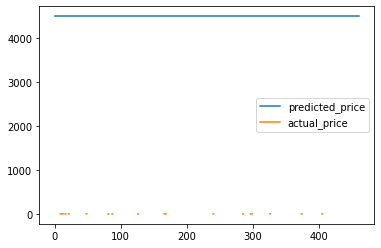

In [57]:
# from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_dataframe_train, y_train)
prediction=rf.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
#idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], columns=['Price'])
predictions_df['Price'] = predictions_df['Price'].apply(np.int64)
predictions_df['Price'] = predictions_df['Price'] + 4500
predictions_df['actual_value'] = y_test
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
y_test = y_test.apply(np.int64)
#print(accuracy_score(test['adj_close_price'],predictions_df['predicted_price']))
print(rf.score(numpy_dataframe_train, y_train))